# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

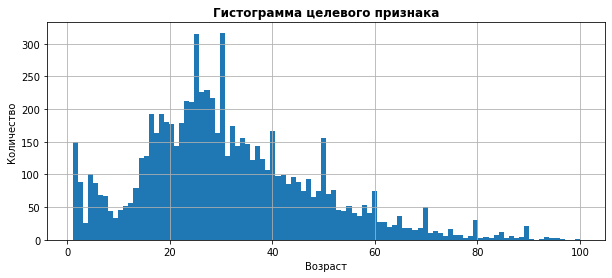

In [22]:
labels.hist(bins=100)
  
plt.title('Гистограмма целевого признака',
          fontweight ="bold")
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.rcParams["figure.figsize"] = (10,4)

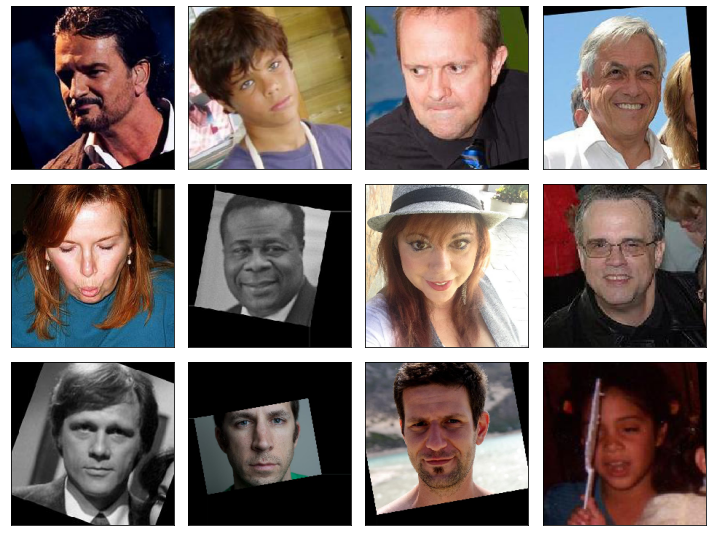

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Датасет состоит из 7591 фотографий.

Больштнство людей на фото в диапазоне от 20 до 41 года. Детей и пожилых людей меньше

Так же отмечается большое количество "шумных" фото, за счет накладывающихся предметов.

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

## Обучение модели

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Вывод консоли
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 114s - loss: 204.8660 - mae: 10.4056 - val_loss: 632.3849 - val_mae: 20.0877
Epoch 2/10
356/356 - 41s - loss: 87.3944 - mae: 7.0922 - val_loss: 123.1090 - val_mae: 8.2698
Epoch 3/10
356/356 - 41s - loss: 56.3617 - mae: 5.7558 - val_loss: 83.0355 - val_mae: 6.7989
Epoch 4/10
356/356 - 41s - loss: 41.4288 - mae: 4.9632 - val_loss: 98.0594 - val_mae: 7.4277
Epoch 5/10
356/356 - 41s - loss: 31.8802 - mae: 4.3635 - val_loss: 70.8377 - val_mae: 6.3042
Epoch 6/10
356/356 - 41s - loss: 26.1412 - mae: 3.9406 - val_loss: 74.3797 - val_mae: 6.3822
Epoch 7/10
356/356 - 41s - loss: 21.7432 - mae: 3.5440 - val_loss: 92.1918 - val_mae: 7.1217
Epoch 8/10
356/356 - 41s - loss: 19.7696 - mae: 3.3835 - val_loss: 67.2342 - val_mae: 6.1477
Epoch 9/10
356/356 - 41s - loss: 15.3840 - mae: 3.0008 - val_loss: 74.9610 - val_mae: 6.4470
Epoch 10/10
356/356 - 41s - loss: 14.0712 - mae: 2.8653 - val_loss: 66.8269 - val_mae: 6.0457

119/119 - 10s - loss: 66.8269 - mae: 6.0457
Test MAE: 6.0457

## Анализ обученной модели

Модель сверточной нейронной сети построена на ResNet50.

За 10 эпох обучения удалось уменьшить MAE с 10 до 2.8 на тренировочной выборке. Дальнейшее обучение возможно улучшит результат.

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. Получение значения МАЕ 6 - хороший показатель, так как для категорий пользователей погрешность в 6 лет не так страшна. В основном по причине , что категории покупателей по возрасту разделяют по 8-12 лет.

Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.